In [1]:
# Import pyomo libraries
import pandas as pd
import pyomo.environ as pe
import pyomo.gdp as pyogdp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from itertools import product

In [2]:
# Define Model
model = pe.ConcreteModel()

In [3]:
class TheatreScheduler:

    def __init__(self, case_file_path, session_file_path):
        """
        Read case and session data into Pandas DataFrames
        Args:
            case_file_path (str): path to case data in CSV format
            session_file_path (str): path to theatre session data in CSV format
        """
        try:
            self.df_cases = pd.read_csv(case_file_path)
        except FileNotFoundError:
            print("Case data not found.")

        try:
            self.df_sessions = pd.read_csv(session_file_path)
        except FileNotFoundError:
            print("Session data not found")
            
        self.model = self.create_model()
    
    def _generate_case_durations(self):
        """
        Generate mapping of cases IDs to median case time for the procedure
        Returns:
            (dict): dictionary with CaseID as key and median case time (mins) for procedure as value
        """
        #return pd.Series(self.df_cases["Median Duration"].values, index=self.df_cases["CaseID"]).to_dict()
        return pd.Series(self.df_cases["Expected Duration"].values, index=self.df_cases["CaseID"]).to_dict()

    def _generate_session_durations(self):
        """
        Generate mapping of all theatre sessions IDs to session duration in minutes
        Returns:
            (dict): dictionary with SessionID as key and session duration as value
        """
        return pd.Series(self.df_sessions["Duration"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_session_start_times(self):
        """
        Generate mapping from SessionID to session start time
        Returns:
            (dict): dictionary with SessionID as key and start time in minutes since midnight as value
        """
        # Convert session start time from HH:MM:SS format into seconds elapsed since midnight
        self.df_sessions.loc[:, "Start"] = pd.to_timedelta(self.df_sessions["Start"])
        self.df_sessions.loc[:, "Start"] = self.df_sessions["Start"].dt.total_seconds() / 60
        return pd.Series(self.df_sessions["Start"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _get_ordinal_case_deadlines(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "TargetDeadline"] = pd.to_datetime(self.df_cases["TargetDeadline"], format="%d/%m/%Y")
        self.df_cases.loc[:, "TargetDeadline"] = self.df_cases["TargetDeadline"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_cases["TargetDeadline"].values, index=self.df_cases["CaseID"]).to_dict()

    def _get_ordinal_session_dates(self):
        """
        #TODO
        Returns:

        """
        self.df_sessions.loc[:, "Date"] = pd.to_datetime(self.df_sessions["Date"], format="%d/%m/%Y")
        self.df_sessions.loc[:, "Date"] = self.df_sessions["Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_sessions["Date"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_disjunctions(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        disjunctions = []
        for (case1, case2, session) in product(cases, cases, sessions):
            if (case1 != case2) and (case2, case1, session) not in disjunctions:
                disjunctions.append((case1, case2, session))

        return disjunctions
    
    def create_model(self):
        model = pe.ConcreteModel()

        # Model Data

        # List of case IDs in surgical waiting list
        model.CASES = pe.Set(initialize=self.df_cases["CaseID"].tolist())
        # List of sessions IDs
        model.SESSIONS = pe.Set(initialize=self.df_sessions["SessionID"].tolist())
        # List of tasks - all possible (caseID, sessionID) combination
        model.TASKS = pe.Set(initialize=model.CASES * model.SESSIONS, dimen=2)
        # The duration (median case time) for each operation
        model.CASE_DURATION = pe.Param(model.CASES, initialize=self._generate_case_durations())
        # The duration of each theatre session
        model.SESSION_DURATION = pe.Param(model.SESSIONS, initialize=self._generate_session_durations())
        # The start time of each theatre session
        model.SESSION_START_TIME = pe.Param(model.SESSIONS, initialize=self._generate_session_start_times())
        # The deadline of each case
        model.CASE_DEADLINES = pe.Param(model.CASES, initialize=self._get_ordinal_case_deadlines())
        # The date of each theatre session
        model.SESSION_DATES = pe.Param(model.SESSIONS, initialize=self._get_ordinal_session_dates())


        model.DISJUNCTIONS = pe.Set(initialize=self._generate_disjunctions(), dimen=3)

        ub = 1440  # seconds in a day
        model.M = pe.Param(initialize=1e3*ub)  # big M
        max_util = 0.85
        num_cases = self.df_cases.shape[0]

        # Decision Variables
        model.SESSION_ASSIGNED = pe.Var(model.TASKS, domain=pe.Binary)
        model.CASE_START_TIME = pe.Var(model.TASKS, bounds=(0, ub), within=pe.PositiveReals)
        model.CASES_IN_SESSION = pe.Var(model.SESSIONS, bounds=(0, num_cases), within=pe.PositiveReals)

        # Objective
        def objective_function(model):
            return pe.summation(model.CASES_IN_SESSION)
            #return sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES for session in model.SESSIONS])
        model.OBJECTIVE = pe.Objective(rule=objective_function, sense=pe.maximize)

        # Constraints

        # Case start time must be after start time of assigned theatre session
        def case_start_time(model, case, session):
            return model.CASE_START_TIME[case, session] >= model.SESSION_START_TIME[session] - \
                   ((1 - model.SESSION_ASSIGNED[(case, session)])*model.M)
        model.CASE_START = pe.Constraint(model.TASKS, rule=case_start_time)

        # Case end time must be before end time of assigned theatre session
        def case_end_time(model, case, session):
            return model.CASE_START_TIME[case, session] + model.CASE_DURATION[case] <= model.SESSION_START_TIME[session] + \
                   model.SESSION_DURATION[session]*max_util + ((1 - model.SESSION_ASSIGNED[(case, session)]) * model.M)
        model.CASE_END_TIME = pe.Constraint(model.TASKS, rule=case_end_time)

        # Cases can be assigned to a maximum of one session
        def session_assignment(model, case):
            return sum([model.SESSION_ASSIGNED[(case, session)] for session in model.SESSIONS]) <= 1
        model.SESSION_ASSIGNMENT = pe.Constraint(model.CASES, rule=session_assignment)

        def set_deadline_condition(model, case, session):
            return model.SESSION_DATES[session] <= model.CASE_DEADLINES[case] + ((1 - model.SESSION_ASSIGNED[case, session])*model.M)
        model.APPLY_DEADLINE = pe.Constraint(model.TASKS, rule=set_deadline_condition)

        def no_case_overlap(model, case1, case2, session):
            return [model.CASE_START_TIME[case1, session] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M),
                    model.CASE_START_TIME[case2, session] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M)]

        model.DISJUNCTIONS_RULE = pyogdp.Disjunction(model.DISJUNCTIONS, rule=no_case_overlap)

        def theatre_util(model, session):
            return model.CASES_IN_SESSION[session] == \
                   sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES])

        model.THEATRE_UTIL = pe.Constraint(model.SESSIONS, rule=theatre_util)

        pe.TransformationFactory("gdp.bigm").apply_to(model)

        return model
    
    def solve(self, solver_name, options=None, solver_path=None, local=True):

        if solver_path is not None:
            solver = pe.SolverFactory(solver_name, executable=solver_path)
        else:
            solver = pe.SolverFactory(solver_name)

        # TODO remove - too similar to alstom
        if options is not None:
            for key, value in options.items():
                solver.options[key] = value

        if local:
            solver_results = solver.solve(self.model, tee=True)
        else:
            solver_manager = pe.SolverManagerFactory("neos")
            solver_results = solver_manager.solve(self.model, opt=solver)

        results = [{"Case": case,
                    "Session": session,
                    "Session Date": self.model.SESSION_DATES[session],
                    "Case Deadline": self.model.CASE_DEADLINES[case],
                    "Days before deadline": self.model.CASE_DEADLINES[case] - self.model.SESSION_DATES[session],
                    "Start": self.model.CASE_START_TIME[case, session](),
                    "Assignment": self.model.SESSION_ASSIGNED[case, session]()}
                   for (case, session) in self.model.TASKS]

        self.df_times = pd.DataFrame(results)

        all_cases = self.model.CASES.value_list
        cases_assigned = []
        for (case, session) in self.model.SESSION_ASSIGNED:
            if self.model.SESSION_ASSIGNED[case, session] == 1:
                cases_assigned.append(case)

        cases_missed = list(set(all_cases).difference(cases_assigned))
        print("Number of cases assigned = {} out of {}:".format(len(cases_assigned), len(all_cases)))
        print("Cases assigned: ", cases_assigned)
        print("Number of cases missed = {} out of {}:".format(len(cases_missed), len(all_cases)))
        print("Cases missed: ", cases_missed)
        self.model.CASES_IN_SESSION.pprint()
        print("Total Objective = {}".format(sum(self.model.CASES_IN_SESSION.get_values().values())))
        print("Number of constraints = {}".format(solver_results["Problem"].__getitem__(0)["Number of constraints"]))
        #self.model.SESSION_ASSIGNED.pprint()
        print(self.df_times[self.df_times["Assignment"] == 1].to_string())
        self.draw_gantt()

    def draw_gantt(self):

        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))

        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    xs = df.loc[(c, s), 'Start'] /60
                    xf = (df.loc[(c, s), 'Start'] + self.df_cases[self.df_cases["CaseID"] == c]["Expected Duration"])/60
                    ax.plot([xs, xf], [s] * 2, c=colors[c_ix % 7], **bar_style)
                    ax.text((xs + xf) / 2, s, c, **text_style)

        ax.set_title('Assigning Ophthalmology Cases to Theatre Sessions')
        ax.set_xlabel('Time')
        ax.set_ylabel('Sessions')
        ax.grid(True)

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        fig.tight_layout()
        plt.show()

In [4]:
# Import cases and sessions data into pyomo model
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "cases.csv")
session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions.csv")
options = {"seconds": 20000}
scheduler = TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Program Files\Cbc-releases.2.10.8-w64-msvc16-md\bin\cbc.exe -seconds 20000 -printingOptions all -import C:\Users\liuda\AppData\Local\Temp\tmpxfz722zy.pyomo.lp -stat=1 -solve -solu C:\Users\liuda\AppData\Local\Temp\tmpxfz722zy.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 20000
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve is modifying 8 integer bounds and re-presolving
Presolve 2972 (-2643) rows, 1578 (-2147) columns and 14188 (-7537) elements
Statistics for presolved model
Original problem has 3592 integers (3592 of which binary)
Presolved problem has 1472 integers (1472 of which binary)
==== 1472 zero objective 2 different
1472 variables have objective of -0
106 variables have objective of 1
==== absolute objective value

Cbc0010I After 2600 nodes, 1158 on tree, -27 best solution, best possible -30 (6.12 seconds)
Cbc0010I After 2700 nodes, 1218 on tree, -27 best solution, best possible -30 (6.32 seconds)
Cbc0010I After 2800 nodes, 1265 on tree, -27 best solution, best possible -30 (6.52 seconds)
Cbc0010I After 2900 nodes, 1322 on tree, -27 best solution, best possible -30 (6.67 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 195 rows 62 columns
Cbc0010I After 3000 nodes, 1368 on tree, -27 best solution, best possible -30 (6.84 seconds)
Cbc0010I After 3100 nodes, 1414 on tree, -27 best solution, best possible -30 (6.98 seconds)
Cbc0010I After 3200 nodes, 1465 on tree, -27 best solution, best possible -30 (7.11 seconds)
Cbc0010I After 3300 nodes, 1497 on tree, -27 best solution, best possible -30 (7.25 seconds)
Cbc0010I After 3400 nodes, 1524 on tree, -27 best solution, best possible -30 (7.40 seconds)
Cbc0010I After 3500 nodes, 1573 on tree, -27 best solution, best possible -30 (7.57 se

Cbc0010I After 10700 nodes, 2909 on tree, -28 best solution, best possible -30 (18.20 seconds)
Cbc0010I After 10800 nodes, 2907 on tree, -28 best solution, best possible -30 (18.35 seconds)
Cbc0010I After 10900 nodes, 2904 on tree, -28 best solution, best possible -30 (18.49 seconds)
Cbc0010I After 11000 nodes, 2907 on tree, -28 best solution, best possible -30 (18.65 seconds)
Cbc0010I After 11100 nodes, 2941 on tree, -28 best solution, best possible -30 (18.75 seconds)
Cbc0010I After 11200 nodes, 2991 on tree, -28 best solution, best possible -30 (18.87 seconds)
Cbc0010I After 11300 nodes, 3035 on tree, -28 best solution, best possible -30 (18.98 seconds)
Cbc0010I After 11400 nodes, 3089 on tree, -28 best solution, best possible -30 (19.09 seconds)
Cbc0010I After 11500 nodes, 3149 on tree, -28 best solution, best possible -30 (19.19 seconds)
Cbc0010I After 11600 nodes, 3142 on tree, -28 best solution, best possible -30 (19.35 seconds)
Cbc0010I After 11700 nodes, 3142 on tree, -28 best

Cbc0010I After 19200 nodes, 5415 on tree, -28 best solution, best possible -30 (30.11 seconds)
Cbc0010I After 19300 nodes, 5475 on tree, -28 best solution, best possible -30 (30.21 seconds)
Cbc0010I After 19400 nodes, 5503 on tree, -28 best solution, best possible -30 (30.50 seconds)
Cbc0010I After 19500 nodes, 5501 on tree, -28 best solution, best possible -30 (30.85 seconds)
Cbc0010I After 19600 nodes, 5498 on tree, -28 best solution, best possible -30 (31.20 seconds)
Cbc0010I After 19700 nodes, 5492 on tree, -28 best solution, best possible -30 (31.61 seconds)
Cbc0010I After 19800 nodes, 5548 on tree, -28 best solution, best possible -30 (31.73 seconds)
Cbc0010I After 19900 nodes, 5606 on tree, -28 best solution, best possible -30 (31.83 seconds)
Cbc0010I After 20000 nodes, 5660 on tree, -28 best solution, best possible -30 (31.92 seconds)
Cbc0010I After 20100 nodes, 5662 on tree, -28 best solution, best possible -30 (32.25 seconds)
Cbc0010I After 20200 nodes, 5661 on tree, -28 best

Cbc0010I After 32000 nodes, 7566 on tree, -28 best solution, best possible -30 (58.23 seconds)
Cbc0010I After 32100 nodes, 7614 on tree, -28 best solution, best possible -30 (58.34 seconds)
Cbc0010I After 32200 nodes, 7617 on tree, -28 best solution, best possible -30 (58.65 seconds)
Cbc0010I After 32300 nodes, 7618 on tree, -28 best solution, best possible -30 (58.92 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 140 rows 49 columns
Cbc0010I After 32400 nodes, 7653 on tree, -28 best solution, best possible -30 (59.09 seconds)
Cbc0010I After 32500 nodes, 7691 on tree, -28 best solution, best possible -30 (59.23 seconds)
Cbc0010I After 32600 nodes, 7693 on tree, -28 best solution, best possible -30 (59.53 seconds)
Cbc0010I After 32700 nodes, 7723 on tree, -28 best solution, best possible -30 (59.70 seconds)
Cbc0010I After 32800 nodes, 7723 on tree, -28 best solution, best possible -30 (59.97 seconds)
Cbc0010I After 32900 nodes, 7767 on tree, -28 best solution, best po

Cbc0010I After 40400 nodes, 9899 on tree, -28 best solution, best possible -30 (74.93 seconds)
Cbc0010I After 40500 nodes, 9930 on tree, -28 best solution, best possible -30 (75.23 seconds)
Cbc0010I After 40600 nodes, 9972 on tree, -28 best solution, best possible -30 (75.39 seconds)
Cbc0010I After 40700 nodes, 10016 on tree, -28 best solution, best possible -30 (75.54 seconds)
Cbc0010I After 40800 nodes, 10028 on tree, -28 best solution, best possible -30 (75.99 seconds)
Cbc0010I After 40900 nodes, 10061 on tree, -28 best solution, best possible -30 (76.22 seconds)
Cbc0010I After 41000 nodes, 10104 on tree, -28 best solution, best possible -30 (76.34 seconds)
Cbc0010I After 41100 nodes, 10104 on tree, -28 best solution, best possible -30 (76.62 seconds)
Cbc0010I After 41200 nodes, 10103 on tree, -28 best solution, best possible -30 (76.76 seconds)
Cbc0010I After 41300 nodes, 10101 on tree, -28 best solution, best possible -30 (76.91 seconds)
Cbc0010I After 41400 nodes, 10096 on tree, 

Cbc0010I After 48800 nodes, 12541 on tree, -28 best solution, best possible -30 (93.88 seconds)
Cbc0010I After 48900 nodes, 12585 on tree, -28 best solution, best possible -30 (93.97 seconds)
Cbc0010I After 49000 nodes, 12610 on tree, -28 best solution, best possible -30 (94.07 seconds)
Cbc0010I After 49100 nodes, 12612 on tree, -28 best solution, best possible -30 (94.20 seconds)
Cbc0010I After 49200 nodes, 12611 on tree, -28 best solution, best possible -30 (94.32 seconds)
Cbc0010I After 49300 nodes, 12611 on tree, -28 best solution, best possible -30 (94.43 seconds)
Cbc0010I After 49400 nodes, 12607 on tree, -28 best solution, best possible -30 (94.54 seconds)
Cbc0010I After 49500 nodes, 12605 on tree, -28 best solution, best possible -30 (94.64 seconds)
Cbc0010I After 49600 nodes, 12603 on tree, -28 best solution, best possible -30 (94.73 seconds)
Cbc0010I After 49700 nodes, 12601 on tree, -28 best solution, best possible -30 (94.81 seconds)
Cbc0010I After 49800 nodes, 12602 on tre

Cbc0010I After 61400 nodes, 14010 on tree, -28 best solution, best possible -30 (114.13 seconds)
Cbc0010I After 61500 nodes, 14016 on tree, -28 best solution, best possible -30 (114.26 seconds)
Cbc0010I After 61600 nodes, 14021 on tree, -28 best solution, best possible -30 (114.46 seconds)
Cbc0010I After 61700 nodes, 14015 on tree, -28 best solution, best possible -30 (114.62 seconds)
Cbc0010I After 61800 nodes, 14008 on tree, -28 best solution, best possible -30 (114.79 seconds)
Cbc0010I After 61900 nodes, 14011 on tree, -28 best solution, best possible -30 (114.96 seconds)
Cbc0010I After 62000 nodes, 14001 on tree, -28 best solution, best possible -30 (115.06 seconds)
Cbc0010I After 62100 nodes, 14016 on tree, -28 best solution, best possible -30 (115.29 seconds)
Cbc0010I After 62200 nodes, 14016 on tree, -28 best solution, best possible -30 (115.54 seconds)
Cbc0010I After 62300 nodes, 14010 on tree, -28 best solution, best possible -30 (115.75 seconds)
Cbc0010I After 62400 nodes, 13

Cbc0010I After 69800 nodes, 14566 on tree, -28 best solution, best possible -30 (127.34 seconds)
Cbc0010I After 69900 nodes, 14565 on tree, -28 best solution, best possible -30 (127.46 seconds)
Cbc0010I After 70000 nodes, 14564 on tree, -28 best solution, best possible -30 (127.60 seconds)
Cbc0010I After 70100 nodes, 14566 on tree, -28 best solution, best possible -30 (127.78 seconds)
Cbc0010I After 70200 nodes, 14565 on tree, -28 best solution, best possible -30 (127.93 seconds)
Cbc0010I After 70300 nodes, 14571 on tree, -28 best solution, best possible -30 (128.04 seconds)
Cbc0010I After 70400 nodes, 14568 on tree, -28 best solution, best possible -30 (128.22 seconds)
Cbc0010I After 70500 nodes, 14564 on tree, -28 best solution, best possible -30 (128.34 seconds)
Cbc0010I After 70600 nodes, 14559 on tree, -28 best solution, best possible -30 (128.48 seconds)
Cbc0010I After 70700 nodes, 14552 on tree, -28 best solution, best possible -30 (128.66 seconds)
Cbc0010I After 70800 nodes, 14

Cbc0010I After 82400 nodes, 14502 on tree, -28 best solution, best possible -30 (145.63 seconds)
Cbc0010I After 82500 nodes, 14503 on tree, -28 best solution, best possible -30 (145.77 seconds)
Cbc0010I After 82600 nodes, 14503 on tree, -28 best solution, best possible -30 (145.94 seconds)
Cbc0010I After 82700 nodes, 14500 on tree, -28 best solution, best possible -30 (146.10 seconds)
Cbc0010I After 82800 nodes, 14500 on tree, -28 best solution, best possible -30 (146.25 seconds)
Cbc0010I After 82900 nodes, 14504 on tree, -28 best solution, best possible -30 (146.40 seconds)
Cbc0010I After 83000 nodes, 14498 on tree, -28 best solution, best possible -30 (146.50 seconds)
Cbc0010I After 83100 nodes, 14501 on tree, -28 best solution, best possible -30 (146.60 seconds)
Cbc0010I After 83200 nodes, 14496 on tree, -28 best solution, best possible -30 (146.70 seconds)
Cbc0010I After 83300 nodes, 14506 on tree, -28 best solution, best possible -30 (146.81 seconds)
Cbc0010I After 83400 nodes, 14

Cbc0010I After 90900 nodes, 14508 on tree, -28 best solution, best possible -30 (157.63 seconds)
Cbc0010I After 91000 nodes, 14501 on tree, -28 best solution, best possible -30 (157.75 seconds)
Cbc0010I After 91100 nodes, 14496 on tree, -28 best solution, best possible -30 (157.85 seconds)
Cbc0010I After 91200 nodes, 14494 on tree, -28 best solution, best possible -30 (157.97 seconds)
Cbc0010I After 91300 nodes, 14501 on tree, -28 best solution, best possible -30 (158.07 seconds)
Cbc0010I After 91400 nodes, 14501 on tree, -28 best solution, best possible -30 (158.20 seconds)
Cbc0010I After 91500 nodes, 14500 on tree, -28 best solution, best possible -30 (158.33 seconds)
Cbc0010I After 91600 nodes, 14501 on tree, -28 best solution, best possible -30 (158.45 seconds)
Cbc0010I After 91700 nodes, 14498 on tree, -28 best solution, best possible -30 (158.58 seconds)
Cbc0010I After 91800 nodes, 14495 on tree, -28 best solution, best possible -30 (158.69 seconds)
Cbc0010I After 91900 nodes, 14

Cbc0010I After 103500 nodes, 14528 on tree, -28 best solution, best possible -30 (172.65 seconds)
Cbc0010I After 103600 nodes, 14524 on tree, -28 best solution, best possible -30 (172.76 seconds)
Cbc0010I After 103700 nodes, 14528 on tree, -28 best solution, best possible -30 (172.90 seconds)
Cbc0010I After 103800 nodes, 14526 on tree, -28 best solution, best possible -30 (173.03 seconds)
Cbc0010I After 103900 nodes, 14526 on tree, -28 best solution, best possible -30 (173.18 seconds)
Cbc0010I After 104000 nodes, 14524 on tree, -28 best solution, best possible -30 (173.28 seconds)
Cbc0010I After 104100 nodes, 14525 on tree, -28 best solution, best possible -30 (173.38 seconds)
Cbc0010I After 104200 nodes, 14520 on tree, -28 best solution, best possible -30 (173.47 seconds)
Cbc0010I After 104300 nodes, 14523 on tree, -28 best solution, best possible -30 (173.57 seconds)
Cbc0010I After 104400 nodes, 14525 on tree, -28 best solution, best possible -30 (173.68 seconds)
Cbc0010I After 10450

Cbc0010I After 111800 nodes, 14527 on tree, -28 best solution, best possible -30 (181.32 seconds)
Cbc0010I After 111900 nodes, 14532 on tree, -28 best solution, best possible -30 (181.46 seconds)
Cbc0010I After 112000 nodes, 14526 on tree, -28 best solution, best possible -30 (181.57 seconds)
Cbc0010I After 112100 nodes, 14525 on tree, -28 best solution, best possible -30 (181.69 seconds)
Cbc0010I After 112200 nodes, 14524 on tree, -28 best solution, best possible -30 (181.81 seconds)
Cbc0010I After 112300 nodes, 14525 on tree, -28 best solution, best possible -30 (181.90 seconds)
Cbc0010I After 112400 nodes, 14524 on tree, -28 best solution, best possible -30 (181.97 seconds)
Cbc0010I After 112500 nodes, 14524 on tree, -28 best solution, best possible -30 (182.07 seconds)
Cbc0010I After 112600 nodes, 14530 on tree, -28 best solution, best possible -30 (182.18 seconds)
Cbc0010I After 112700 nodes, 14523 on tree, -28 best solution, best possible -30 (182.28 seconds)
Cbc0010I After 11280

Cbc0010I After 120200 nodes, 14527 on tree, -28 best solution, best possible -30 (190.19 seconds)
Cbc0010I After 120300 nodes, 14521 on tree, -28 best solution, best possible -30 (190.27 seconds)
Cbc0010I After 120400 nodes, 14520 on tree, -28 best solution, best possible -30 (190.37 seconds)
Cbc0010I After 120500 nodes, 14524 on tree, -28 best solution, best possible -30 (190.49 seconds)
Cbc0010I After 120600 nodes, 14526 on tree, -28 best solution, best possible -30 (190.61 seconds)
Cbc0010I After 120700 nodes, 14523 on tree, -28 best solution, best possible -30 (190.71 seconds)
Cbc0010I After 120800 nodes, 14520 on tree, -28 best solution, best possible -30 (190.79 seconds)
Cbc0010I After 120900 nodes, 14525 on tree, -28 best solution, best possible -30 (190.89 seconds)
Cbc0010I After 121000 nodes, 14521 on tree, -28 best solution, best possible -30 (190.99 seconds)
Cbc0010I After 121100 nodes, 14519 on tree, -28 best solution, best possible -30 (191.10 seconds)
Cbc0010I After 12120

Cbc0010I After 132600 nodes, 14522 on tree, -28 best solution, best possible -30 (203.20 seconds)
Cbc0010I After 132700 nodes, 14528 on tree, -28 best solution, best possible -30 (203.29 seconds)
Cbc0010I After 132800 nodes, 14526 on tree, -28 best solution, best possible -30 (203.40 seconds)
Cbc0010I After 132900 nodes, 14527 on tree, -28 best solution, best possible -30 (203.49 seconds)
Cbc0010I After 133000 nodes, 14526 on tree, -28 best solution, best possible -30 (203.57 seconds)
Cbc0010I After 133100 nodes, 14525 on tree, -28 best solution, best possible -30 (203.66 seconds)
Cbc0010I After 133200 nodes, 14523 on tree, -28 best solution, best possible -30 (203.77 seconds)
Cbc0010I After 133300 nodes, 14523 on tree, -28 best solution, best possible -30 (203.88 seconds)
Cbc0010I After 133400 nodes, 14528 on tree, -28 best solution, best possible -30 (203.98 seconds)
Cbc0010I After 133500 nodes, 14529 on tree, -28 best solution, best possible -30 (204.07 seconds)
Cbc0010I After 13360

Cbc0010I After 141000 nodes, 14524 on tree, -28 best solution, best possible -30 (211.73 seconds)
Cbc0010I After 141100 nodes, 14528 on tree, -28 best solution, best possible -30 (211.83 seconds)
Cbc0010I After 141200 nodes, 14526 on tree, -28 best solution, best possible -30 (211.94 seconds)
Cbc0010I After 141300 nodes, 14527 on tree, -28 best solution, best possible -30 (212.08 seconds)
Cbc0010I After 141400 nodes, 14532 on tree, -28 best solution, best possible -30 (212.22 seconds)
Cbc0010I After 141500 nodes, 14530 on tree, -28 best solution, best possible -30 (212.32 seconds)
Cbc0010I After 141600 nodes, 14529 on tree, -28 best solution, best possible -30 (212.43 seconds)
Cbc0010I After 141700 nodes, 14527 on tree, -28 best solution, best possible -30 (212.56 seconds)
Cbc0010I After 141800 nodes, 14531 on tree, -28 best solution, best possible -30 (212.67 seconds)
Cbc0010I After 141900 nodes, 14527 on tree, -28 best solution, best possible -30 (212.78 seconds)
Cbc0010I After 14200

Cbc0010I After 153500 nodes, 14525 on tree, -28 best solution, best possible -30 (225.27 seconds)
Cbc0010I After 153600 nodes, 14520 on tree, -28 best solution, best possible -30 (225.38 seconds)
Cbc0010I After 153700 nodes, 14523 on tree, -28 best solution, best possible -30 (225.50 seconds)
Cbc0010I After 153800 nodes, 14526 on tree, -28 best solution, best possible -30 (225.67 seconds)
Cbc0010I After 153900 nodes, 14521 on tree, -28 best solution, best possible -30 (225.79 seconds)
Cbc0010I After 154000 nodes, 14522 on tree, -28 best solution, best possible -30 (225.91 seconds)
Cbc0010I After 154100 nodes, 14524 on tree, -28 best solution, best possible -30 (226.00 seconds)
Cbc0010I After 154200 nodes, 14528 on tree, -28 best solution, best possible -30 (226.13 seconds)
Cbc0010I After 154300 nodes, 14527 on tree, -28 best solution, best possible -30 (226.27 seconds)
Cbc0010I After 154400 nodes, 14528 on tree, -28 best solution, best possible -30 (226.39 seconds)
Cbc0010I After 15450

Cbc0010I After 161900 nodes, 14523 on tree, -28 best solution, best possible -30 (234.37 seconds)
Cbc0010I After 162000 nodes, 14520 on tree, -28 best solution, best possible -30 (234.48 seconds)
Cbc0010I After 162100 nodes, 14526 on tree, -28 best solution, best possible -30 (234.55 seconds)
Cbc0010I After 162200 nodes, 14519 on tree, -28 best solution, best possible -30 (234.65 seconds)
Cbc0010I After 162300 nodes, 14524 on tree, -28 best solution, best possible -30 (234.79 seconds)
Cbc0010I After 162400 nodes, 14523 on tree, -28 best solution, best possible -30 (234.91 seconds)
Cbc0010I After 162500 nodes, 14522 on tree, -28 best solution, best possible -30 (235.01 seconds)
Cbc0010I After 162600 nodes, 14524 on tree, -28 best solution, best possible -30 (235.11 seconds)
Cbc0010I After 162700 nodes, 14521 on tree, -28 best solution, best possible -30 (235.19 seconds)
Cbc0010I After 162800 nodes, 14521 on tree, -28 best solution, best possible -30 (235.26 seconds)
Cbc0010I After 16290

Cbc0010I After 174300 nodes, 14521 on tree, -28 best solution, best possible -30 (248.25 seconds)
Cbc0010I After 174400 nodes, 14520 on tree, -28 best solution, best possible -30 (248.39 seconds)
Cbc0010I After 174500 nodes, 14519 on tree, -28 best solution, best possible -30 (248.51 seconds)
Cbc0010I After 174600 nodes, 14524 on tree, -28 best solution, best possible -30 (248.69 seconds)
Cbc0010I After 174700 nodes, 14517 on tree, -28 best solution, best possible -30 (248.88 seconds)
Cbc0010I After 174800 nodes, 14517 on tree, -28 best solution, best possible -30 (249.01 seconds)
Cbc0010I After 174900 nodes, 14522 on tree, -28 best solution, best possible -30 (249.14 seconds)
Cbc0010I After 175000 nodes, 14527 on tree, -28 best solution, best possible -30 (249.25 seconds)
Cbc0010I After 175100 nodes, 14525 on tree, -28 best solution, best possible -30 (249.40 seconds)
Cbc0010I After 175200 nodes, 14534 on tree, -28 best solution, best possible -30 (249.56 seconds)
Cbc0010I After 17530

Cbc0010I After 182700 nodes, 14522 on tree, -28 best solution, best possible -30 (258.77 seconds)
Cbc0010I After 182800 nodes, 14521 on tree, -28 best solution, best possible -30 (258.91 seconds)
Cbc0010I After 182900 nodes, 14526 on tree, -28 best solution, best possible -30 (259.05 seconds)
Cbc0010I After 183000 nodes, 14522 on tree, -28 best solution, best possible -30 (259.19 seconds)
Cbc0010I After 183100 nodes, 14530 on tree, -28 best solution, best possible -30 (259.32 seconds)
Cbc0010I After 183200 nodes, 14529 on tree, -28 best solution, best possible -30 (259.44 seconds)
Cbc0010I After 183300 nodes, 14528 on tree, -28 best solution, best possible -30 (259.53 seconds)
Cbc0010I After 183400 nodes, 14529 on tree, -28 best solution, best possible -30 (259.63 seconds)
Cbc0010I After 183500 nodes, 14532 on tree, -28 best solution, best possible -30 (259.76 seconds)
Cbc0010I After 183600 nodes, 14532 on tree, -28 best solution, best possible -30 (259.86 seconds)
Cbc0010I After 18370

Cbc0010I After 191100 nodes, 14522 on tree, -28 best solution, best possible -30 (268.80 seconds)
Cbc0010I After 191200 nodes, 14526 on tree, -28 best solution, best possible -30 (268.95 seconds)
Cbc0010I After 191300 nodes, 14528 on tree, -28 best solution, best possible -30 (269.12 seconds)
Cbc0010I After 191400 nodes, 14526 on tree, -28 best solution, best possible -30 (269.27 seconds)
Cbc0010I After 191500 nodes, 14520 on tree, -28 best solution, best possible -30 (269.41 seconds)
Cbc0010I After 191600 nodes, 14524 on tree, -28 best solution, best possible -30 (269.54 seconds)
Cbc0010I After 191700 nodes, 14522 on tree, -28 best solution, best possible -30 (269.67 seconds)
Cbc0010I After 191800 nodes, 14518 on tree, -28 best solution, best possible -30 (269.79 seconds)
Cbc0010I After 191900 nodes, 14521 on tree, -28 best solution, best possible -30 (269.95 seconds)
Cbc0010I After 192000 nodes, 14527 on tree, -28 best solution, best possible -30 (270.09 seconds)
Cbc0010I After 19210

Cbc0010I After 203500 nodes, 14529 on tree, -28 best solution, best possible -30 (284.29 seconds)
Cbc0010I After 203600 nodes, 14528 on tree, -28 best solution, best possible -30 (284.45 seconds)
Cbc0010I After 203700 nodes, 14529 on tree, -28 best solution, best possible -30 (284.60 seconds)
Cbc0010I After 203800 nodes, 14522 on tree, -28 best solution, best possible -30 (284.83 seconds)
Cbc0010I After 203900 nodes, 14524 on tree, -28 best solution, best possible -30 (284.93 seconds)
Cbc0010I After 204000 nodes, 14525 on tree, -28 best solution, best possible -30 (285.02 seconds)
Cbc0010I After 204100 nodes, 14521 on tree, -28 best solution, best possible -30 (285.12 seconds)
Cbc0010I After 204200 nodes, 14523 on tree, -28 best solution, best possible -30 (285.23 seconds)
Cbc0010I After 204300 nodes, 14521 on tree, -28 best solution, best possible -30 (285.35 seconds)
Cbc0010I After 204400 nodes, 14521 on tree, -28 best solution, best possible -30 (285.46 seconds)
Cbc0010I After 20450

Cbc0010I After 211900 nodes, 14524 on tree, -28 best solution, best possible -30 (293.91 seconds)
Cbc0010I After 212000 nodes, 14525 on tree, -28 best solution, best possible -30 (294.02 seconds)
Cbc0010I After 212100 nodes, 14523 on tree, -28 best solution, best possible -30 (294.12 seconds)
Cbc0010I After 212200 nodes, 14520 on tree, -28 best solution, best possible -30 (294.23 seconds)
Cbc0010I After 212300 nodes, 14523 on tree, -28 best solution, best possible -30 (294.37 seconds)
Cbc0010I After 212400 nodes, 14521 on tree, -28 best solution, best possible -30 (294.48 seconds)
Cbc0010I After 212500 nodes, 14520 on tree, -28 best solution, best possible -30 (294.61 seconds)
Cbc0010I After 212600 nodes, 14519 on tree, -28 best solution, best possible -30 (294.74 seconds)
Cbc0010I After 212700 nodes, 14522 on tree, -28 best solution, best possible -30 (294.87 seconds)
Cbc0010I After 212800 nodes, 14522 on tree, -28 best solution, best possible -30 (294.97 seconds)
Cbc0010I After 21290

Cbc0010I After 220200 nodes, 14528 on tree, -28 best solution, best possible -30 (303.69 seconds)
Cbc0010I After 220300 nodes, 14521 on tree, -28 best solution, best possible -30 (303.80 seconds)
Cbc0010I After 220400 nodes, 14523 on tree, -28 best solution, best possible -30 (303.92 seconds)
Cbc0010I After 220500 nodes, 14520 on tree, -28 best solution, best possible -30 (304.05 seconds)
Cbc0010I After 220600 nodes, 14522 on tree, -28 best solution, best possible -30 (304.22 seconds)
Cbc0010I After 220700 nodes, 14520 on tree, -28 best solution, best possible -30 (304.35 seconds)
Cbc0010I After 220800 nodes, 14520 on tree, -28 best solution, best possible -30 (304.48 seconds)
Cbc0010I After 220900 nodes, 14521 on tree, -28 best solution, best possible -30 (304.60 seconds)
Cbc0010I After 221000 nodes, 14524 on tree, -28 best solution, best possible -30 (304.73 seconds)
Cbc0010I After 221100 nodes, 14523 on tree, -28 best solution, best possible -30 (304.85 seconds)
Cbc0010I After 22120

Cbc0010I After 232500 nodes, 14517 on tree, -28 best solution, best possible -30 (16247.59 seconds)
Cbc0010I After 232600 nodes, 14520 on tree, -28 best solution, best possible -30 (16247.71 seconds)
Cbc0010I After 232700 nodes, 14520 on tree, -28 best solution, best possible -30 (16247.81 seconds)
Cbc0010I After 232800 nodes, 14523 on tree, -28 best solution, best possible -30 (16247.91 seconds)
Cbc0010I After 232900 nodes, 14523 on tree, -28 best solution, best possible -30 (16248.02 seconds)
Cbc0010I After 233000 nodes, 14517 on tree, -28 best solution, best possible -30 (16248.14 seconds)
Cbc0010I After 233100 nodes, 14514 on tree, -28 best solution, best possible -30 (16248.23 seconds)
Cbc0010I After 233200 nodes, 14527 on tree, -28 best solution, best possible -30 (16248.34 seconds)
Cbc0010I After 233300 nodes, 14522 on tree, -28 best solution, best possible -30 (16248.44 seconds)
Cbc0010I After 233400 nodes, 14521 on tree, -28 best solution, best possible -30 (16248.52 seconds)


Cbc0010I After 244700 nodes, 14516 on tree, -28 best solution, best possible -30 (16259.88 seconds)
Cbc0010I After 244800 nodes, 14521 on tree, -28 best solution, best possible -30 (16260.04 seconds)
Cbc0010I After 244900 nodes, 14520 on tree, -28 best solution, best possible -30 (16260.17 seconds)
Cbc0010I After 245000 nodes, 14520 on tree, -28 best solution, best possible -30 (16260.30 seconds)
Cbc0010I After 245100 nodes, 14521 on tree, -28 best solution, best possible -30 (16260.39 seconds)
Cbc0010I After 245200 nodes, 14519 on tree, -28 best solution, best possible -30 (16260.51 seconds)
Cbc0010I After 245300 nodes, 14517 on tree, -28 best solution, best possible -30 (16260.61 seconds)
Cbc0010I After 245400 nodes, 14522 on tree, -28 best solution, best possible -30 (16260.70 seconds)
Cbc0010I After 245500 nodes, 14521 on tree, -28 best solution, best possible -30 (16260.79 seconds)
Cbc0010I After 245600 nodes, 14519 on tree, -28 best solution, best possible -30 (16260.90 seconds)


Cbc0010I After 252900 nodes, 14534 on tree, -28 best solution, best possible -30 (16269.08 seconds)
Cbc0010I After 253000 nodes, 14532 on tree, -28 best solution, best possible -30 (16269.19 seconds)
Cbc0010I After 253100 nodes, 14533 on tree, -28 best solution, best possible -30 (16269.30 seconds)
Cbc0010I After 253200 nodes, 14534 on tree, -28 best solution, best possible -30 (16269.41 seconds)
Cbc0010I After 253300 nodes, 14529 on tree, -28 best solution, best possible -30 (16269.51 seconds)
Cbc0010I After 253400 nodes, 14531 on tree, -28 best solution, best possible -30 (16269.60 seconds)
Cbc0010I After 253500 nodes, 14532 on tree, -28 best solution, best possible -30 (16269.70 seconds)
Cbc0010I After 253600 nodes, 14531 on tree, -28 best solution, best possible -30 (16269.80 seconds)
Cbc0010I After 253700 nodes, 14526 on tree, -28 best solution, best possible -30 (16269.91 seconds)
Cbc0010I After 253800 nodes, 14528 on tree, -28 best solution, best possible -30 (16270.03 seconds)


Cbc0010I After 265100 nodes, 14527 on tree, -28 best solution, best possible -30 (16281.87 seconds)
Cbc0010I After 265200 nodes, 14524 on tree, -28 best solution, best possible -30 (16282.01 seconds)
Cbc0010I After 265300 nodes, 14526 on tree, -28 best solution, best possible -30 (16282.14 seconds)
Cbc0010I After 265400 nodes, 14523 on tree, -28 best solution, best possible -30 (16282.28 seconds)
Cbc0010I After 265500 nodes, 14521 on tree, -28 best solution, best possible -30 (16282.37 seconds)
Cbc0010I After 265600 nodes, 14527 on tree, -28 best solution, best possible -30 (16282.46 seconds)
Cbc0010I After 265700 nodes, 14523 on tree, -28 best solution, best possible -30 (16282.57 seconds)
Cbc0010I After 265800 nodes, 14524 on tree, -28 best solution, best possible -30 (16282.74 seconds)
Cbc0010I After 265900 nodes, 14523 on tree, -28 best solution, best possible -30 (16282.90 seconds)
Cbc0010I After 266000 nodes, 14518 on tree, -28 best solution, best possible -30 (16283.05 seconds)


Cbc0010I After 273300 nodes, 14525 on tree, -28 best solution, best possible -30 (16291.32 seconds)
Cbc0010I After 273400 nodes, 14527 on tree, -28 best solution, best possible -30 (16291.42 seconds)
Cbc0010I After 273500 nodes, 14525 on tree, -28 best solution, best possible -30 (16291.52 seconds)
Cbc0010I After 273600 nodes, 14527 on tree, -28 best solution, best possible -30 (16291.62 seconds)
Cbc0010I After 273700 nodes, 14524 on tree, -28 best solution, best possible -30 (16291.73 seconds)
Cbc0010I After 273800 nodes, 14526 on tree, -28 best solution, best possible -30 (16291.82 seconds)
Cbc0010I After 273900 nodes, 14521 on tree, -28 best solution, best possible -30 (16291.92 seconds)
Cbc0010I After 274000 nodes, 14525 on tree, -28 best solution, best possible -30 (16292.03 seconds)
Cbc0010I After 274100 nodes, 14521 on tree, -28 best solution, best possible -30 (16292.12 seconds)
Cbc0010I After 274200 nodes, 14524 on tree, -28 best solution, best possible -30 (16292.20 seconds)


Cbc0010I After 281500 nodes, 14527 on tree, -28 best solution, best possible -30 (16299.42 seconds)
Cbc0010I After 281600 nodes, 14525 on tree, -28 best solution, best possible -30 (16299.52 seconds)
Cbc0010I After 281700 nodes, 14527 on tree, -28 best solution, best possible -30 (16299.63 seconds)
Cbc0010I After 281800 nodes, 14523 on tree, -28 best solution, best possible -30 (16299.71 seconds)
Cbc0010I After 281900 nodes, 14521 on tree, -28 best solution, best possible -30 (16299.81 seconds)
Cbc0010I After 282000 nodes, 14525 on tree, -28 best solution, best possible -30 (16299.91 seconds)
Cbc0010I After 282100 nodes, 14524 on tree, -28 best solution, best possible -30 (16300.00 seconds)
Cbc0010I After 282200 nodes, 14524 on tree, -28 best solution, best possible -30 (16300.09 seconds)
Cbc0010I After 282300 nodes, 14522 on tree, -28 best solution, best possible -30 (16300.18 seconds)
Cbc0010I After 282400 nodes, 14524 on tree, -28 best solution, best possible -30 (16300.29 seconds)


Cbc0010I After 289700 nodes, 14528 on tree, -28 best solution, best possible -30 (16308.42 seconds)
Cbc0010I After 289800 nodes, 14526 on tree, -28 best solution, best possible -30 (16308.54 seconds)
Cbc0010I After 289900 nodes, 14522 on tree, -28 best solution, best possible -30 (16308.66 seconds)
Cbc0010I After 290000 nodes, 14519 on tree, -28 best solution, best possible -30 (16308.80 seconds)
Cbc0010I After 290100 nodes, 14522 on tree, -28 best solution, best possible -30 (16308.92 seconds)
Cbc0010I After 290200 nodes, 14524 on tree, -28 best solution, best possible -30 (16309.04 seconds)
Cbc0010I After 290300 nodes, 14527 on tree, -28 best solution, best possible -30 (16309.18 seconds)
Cbc0010I After 290400 nodes, 14524 on tree, -28 best solution, best possible -30 (16309.35 seconds)
Cbc0010I After 290500 nodes, 14522 on tree, -28 best solution, best possible -30 (16309.50 seconds)
Cbc0010I After 290600 nodes, 14522 on tree, -28 best solution, best possible -30 (16309.62 seconds)


    containing a solution
Number of cases assigned = 28 out of 30:
Cases assigned:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]
Number of cases missed = 2 out of 30:
Cases missed:  [25, 13]
CASES_IN_SESSION : Size=4, Index=SESSIONS
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    1001 :     0 :   9.0 :    30 : False : False : PositiveReals
    1002 :     0 :   7.0 :    30 : False : False : PositiveReals
    1003 :     0 :   7.0 :    30 : False : False : PositiveReals
    1004 :     0 :   5.0 :    30 : False : False : PositiveReals
Total Objective = 28.0
Number of constraints = 2972
     Case  Session  Session Date  Case Deadline  Days before deadline  Start  Assignment
2       1     1003        737593         737613                    20  680.0         1.0
6       2     1003        737593         737623                    30  854.5         1.0
8       3     1001        737579         737581                     2  

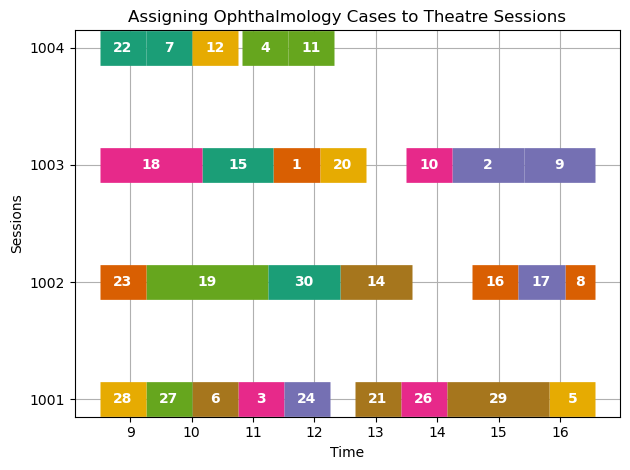

In [5]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)

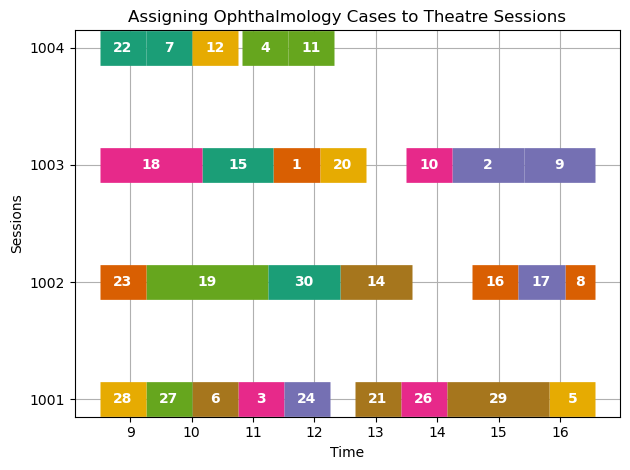

In [6]:
scheduler.draw_gantt()